# Crack Detection using Custom CNN and Grad-CAM
This script builds a binary classification CNN to detect cracks in images and uses Grad-CAM
for visualizing pixel regions responsible for the prediction.

## Step 1: Import Libraries
Import necessary libraries for data handling, model building, training, and visualization.

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, classification_report
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import shutil
from tqdm import tqdm
import random
import seaborn as sns

# Grad-CAM Imports
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

## Step 2: Organize Images
Organize crack and non-crack images into separate directories. 
Make sure to delete the 'images' directory, all masks and other things than data/test and data/train after executing this cell.

In [2]:
def organize_images(base_dir):
    # Define source and destination directories
    source_dir = os.path.join(base_dir, 'images')
    crack_dir = os.path.join(base_dir, 'crack')
    noncrack_dir = os.path.join(base_dir, 'noncrack')
    
    # Create destination directories if they don't exist
    os.makedirs(crack_dir, exist_ok=True)
    os.makedirs(noncrack_dir, exist_ok=True)
    
    # Get list of files in source directory
    try:
        os.listdir(source_dir)
    except FileNotFoundError:
        print(f"Directory {source_dir} not found.")
        return
    files = os.listdir(source_dir)
    
    # Move files to appropriate directories
    for file in files:
        source_path = os.path.join(source_dir, file)
        if file.startswith('noncrack'):
            dest_path = os.path.join(noncrack_dir, file)
        else:
            dest_path = os.path.join(crack_dir, file)
        shutil.move(source_path, dest_path)
    
    print(f"Organized files in {base_dir}")

# Process both test and train directories
data_dirs = ['data/test', 'data/train']

for dir_path in data_dirs:
    organize_images(dir_path)

Directory data/test/images not found.
Directory data/train/images not found.


## Step 2: Data Preparation
Define dataset paths, transformations, and data loaders.

The noncrack images are duplicated to match the number of crack images so that distribution is 50%-50%.

In [3]:
# Paths to the dataset
train_dir = "data/train"
test_dir = "data/test"

img_size = 160

# Transformations for Data Augmentation and Normalization
train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Loading the datasets with subset selection
def get_subset_dataset(full_dataset, percentage=0.1):
    total_size = len(full_dataset)
    subset_size = int(total_size * percentage)
    
    # Get random indices for the subset
    indices = torch.randperm(total_size)[:subset_size]
    
    return torch.utils.data.Subset(full_dataset, indices)

def balance_noncrack_images(dataset):
    samples = dataset.samples
    crack_samples = [(path, idx) for path, idx in samples if idx == dataset.class_to_idx['crack']]
    noncrack_samples = [(path, idx) for path, idx in samples if idx == dataset.class_to_idx['noncrack']]
    
    # Calculate how many more noncrack samples we need
    samples_to_add = len(crack_samples) - len(noncrack_samples)
    if samples_to_add <= 0:
        return dataset
    
    # Randomly select noncrack samples to duplicate
    additional_samples = random.choices(noncrack_samples, k=samples_to_add)
    dataset.samples = samples + additional_samples
    return dataset

# Load full datasets
full_train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
full_test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

# Balance noncrack images to match crack images
full_train_data = balance_noncrack_images(full_train_data)
full_test_data = balance_noncrack_images(full_test_data)

# Create subsets
train_data = get_subset_dataset(full_train_data, 1)
test_data = get_subset_dataset(full_test_data, 1)

print(f"Training with {len(train_data)} images")
print(f"Testing with {len(test_data)} images")

# DataLoaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

print("Data Preparation Complete!")

Training with 16808 images
Testing with 2966 images
Data Preparation Complete!


## Step 3: Define WeaklyUNet Model
Build a U-Net based architecture for weakly supervised crack detection

In [4]:
class WeaklyUNet(nn.Module):
    def __init__(self):
        super(WeaklyUNet, self).__init__()
        
        # Encoder (downsampling)
        self.enc1 = self._make_encoder_layer(3, 64)
        self.enc2 = self._make_encoder_layer(64, 128)
        self.enc3 = self._make_encoder_layer(128, 256)
        self.enc4 = self._make_encoder_layer(256, 512)
        
        # Decoder (upsampling)
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self._make_decoder_layer(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self._make_decoder_layer(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self._make_decoder_layer(128, 64)
        
        # Classification branch
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )
        
        # Final convolution for feature maps
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)
        
    def _make_encoder_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def _make_decoder_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Encoder with stored intermediate outputs
        e1 = self.enc1(x)
        p1 = nn.MaxPool2d(2)(e1)
        
        e2 = self.enc2(p1)
        p2 = nn.MaxPool2d(2)(e2)
        
        e3 = self.enc3(p2)
        p3 = nn.MaxPool2d(2)(e3)
        
        # Bottom
        e4 = self.enc4(p3)
        
        # Classification branch
        gap = self.gap(e4)
        gap = gap.view(gap.size(0), -1)
        classification = self.classifier(gap)
        
        # Decoder
        d3 = self.up3(e4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        
        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        
        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        
        # Final feature maps
        feature_maps = self.final_conv(d1)
        
        return classification, feature_maps

# Initialize Model
model = WeaklyUNet()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, verbose=True)

print(model)

WeaklyUNet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, t

/Users/luncenok/Studia/sem5/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## Step 4: Train the Model
Train the model using weakly supervised learning

/var/folders/yc/wnx9vsb14tx1110ygs64rfvh0000gn/T/ipykernel_97326/3601242125.py:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("crack_dete

Training new model...
Loading training history...


Epoch 1/5: 100%|██████████| 263/263 [1:18:13<00:00, 17.85s/it]


Epoch 1/5:
Loss: 0.3022, Accuracy: 87.06%


Epoch 2/5: 100%|██████████| 263/263 [1:24:16<00:00, 19.23s/it]


Epoch 2/5:
Loss: 0.2363, Accuracy: 91.10%


Epoch 3/5: 100%|██████████| 263/263 [1:24:11<00:00, 19.21s/it]


Epoch 3/5:
Loss: 0.1912, Accuracy: 92.94%


Epoch 4/5: 100%|██████████| 263/263 [1:25:43<00:00, 19.56s/it]


Epoch 4/5:
Loss: 0.1531, Accuracy: 94.77%


Epoch 5/5: 100%|██████████| 263/263 [1:24:16<00:00, 19.23s/it]


Epoch 5/5:
Loss: 0.1396, Accuracy: 95.00%
Saving model and training history...


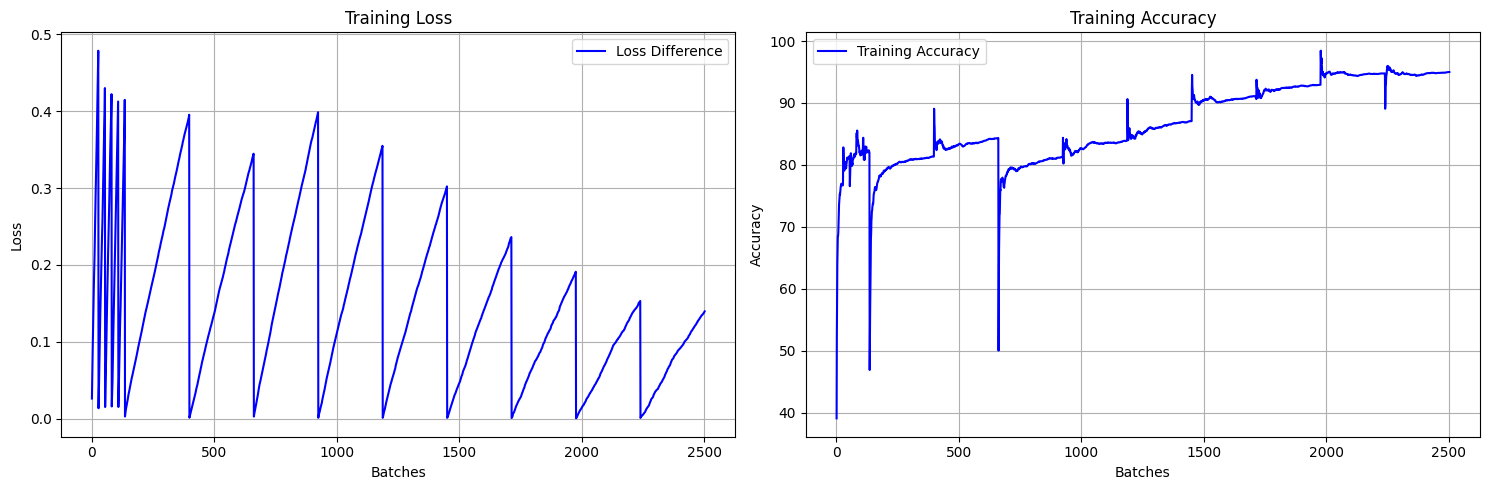

In [6]:
def train_weakly_supervised(model, train_loader, criterion, optimizer, num_epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    history = {'train_loss': [], 'train_acc': []}
    if os.path.exists("training_history.npy"):
        print("Loading training history...")
        history = np.load("training_history.npy", allow_pickle=True).item()
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            classifications, feature_maps = model(inputs)
            loss = criterion(classifications.squeeze(), labels.float())
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            predicted = (torch.sigmoid(classifications) > 0.5).float()
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()
        
            epoch_loss = running_loss / len(train_loader)
            epoch_acc = 100 * correct / total
            
            history['train_loss'].append(epoch_loss)
            history['train_acc'].append(epoch_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')
    
    return history

def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    plt.figure(figsize=(15, 5))
    
    # Plot loss differences
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Loss Difference')
    plt.title('Training Loss')
    plt.xlabel('Batches')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Batches')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Check if pre-trained model and history exist
if os.path.exists("crack_detection_model.pth"):
    print("Loading pre-trained model...")
    model.load_state_dict(torch.load("crack_detection_model.pth"))
    if os.path.exists("training_history.npy"):
        print("Loading training history...")
        history = np.load("training_history.npy", allow_pickle=True).item()
else:
    print("Training new model...")
    model.load_state_dict(torch.load("crack_detection_model.pth"))
    history = train_weakly_supervised(model, train_loader, criterion, optimizer, num_epochs=5)
    print("Saving model and training history...")
    torch.save(model.state_dict(), "crack_detection_model.pth")
    np.save("training_history.npy", history)

# Plot training history if available
if 'history' in locals():
    plot_training_history(history)

## Training in details:

First model was trained for 5 epochs on images with size 40x40 to detect large cracks in images and to make computations faster. Then it was 80x80 To detect smaller cracks that are only visible in higher resolution. The training loss spikes are because it is just sum for each epoch and top of the spike is the loss for the whole epoch. Accuracy dropped and loss increased because all images from training set were used for training. Before that just 10% of images were used for training. Then resolution was increased to 160x160 and instead of resuming training for larger resolution i forgot and rerun everyting again and there is another drop in plot. 1 epoch for 160x160 took 1h 36min and it was trained 7 epoch for 160x160. Cracks were much better visible in visualizations below between 80x80 and 160x160.

## Step 5: Evaluate Model Performance
Evaluate the model on test data and visualize results


Detailed Metrics:
No saved predictions found. Computing predictions...
Computing predictions...


Evaluating model: 100%|██████████| 2966/2966 [05:19<00:00,  9.30it/s]


Saving predictions...


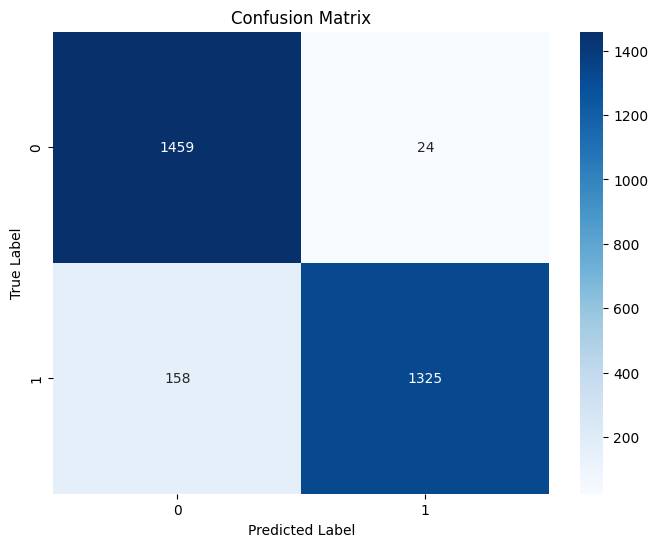

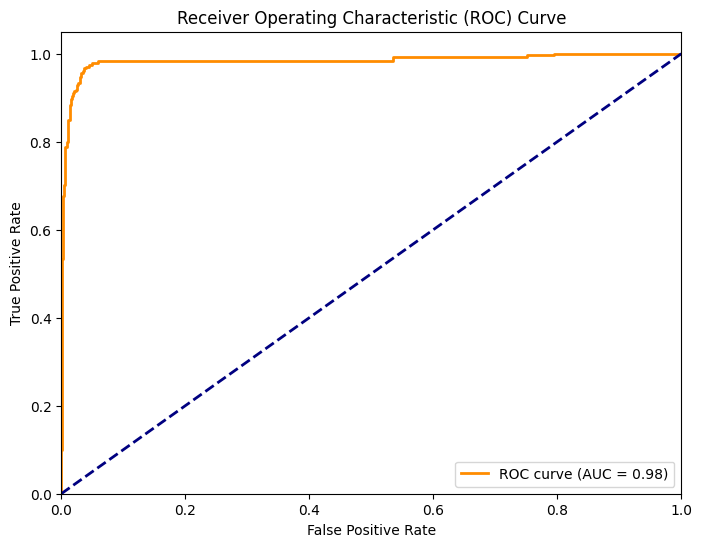


Classification Report:
              precision    recall  f1-score   support

    Noncrack       0.90      0.98      0.94      1483
       Crack       0.98      0.89      0.94      1483

    accuracy                           0.94      2966
   macro avg       0.94      0.94      0.94      2966
weighted avg       0.94      0.94      0.94      2966



In [8]:
def evaluate_model(model=None, test_loader=None):
    """
    Evaluate model performance using saved predictions.
    If model and test_loader are provided, they are ignored as we use saved predictions.
    """
    print("Loading saved predictions...")
    saved_data = np.load('model_predictions.npy', allow_pickle=True).item()
    
    predictions = np.round(saved_data['predictions'])
    labels = saved_data['labels']
    
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    
    print(f"\nTest Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    return accuracy, precision, recall, f1

def save_predictions(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    all_paths = []
    
    # Get the root dataset and indices
    dataset = test_loader.dataset
    indices = range(len(dataset))  # Default indices
    if hasattr(dataset, 'indices'):
        indices = dataset.indices
    
    while not hasattr(dataset, 'samples'):
        dataset = dataset.dataset
    
    print("Computing predictions...")
    with torch.no_grad():
        for i in tqdm(range(len(indices)), desc="Evaluating model"):
            idx = indices[i] if hasattr(test_loader.dataset, 'indices') else i
            img, label = dataset[idx]
            img = img.unsqueeze(0)  # Add batch dimension
            
            outputs, _ = model(img)
            probs = torch.sigmoid(outputs).squeeze()
            preds = (probs > 0.5).float()
            
            all_preds.append(preds.cpu().numpy())
            all_labels.append(label)
            all_probs.append(probs.cpu().numpy())
            all_paths.append(dataset.samples[idx][0])
    
    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    all_paths = np.array(all_paths)
    
    # Save predictions
    print("Saving predictions...")
    np.save('model_predictions.npy', {
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs,
        'paths': all_paths
    })
    return all_preds, all_labels, all_probs, all_paths

def plot_metrics(model=None, test_loader=None):
    # Try to load saved predictions
    if os.path.exists('model_predictions.npy'):
        print("Loading saved predictions...")
        data = np.load('model_predictions.npy', allow_pickle=True).item()
        all_preds = data['predictions']
        all_labels = data['labels']
        all_probs = data['probabilities']
        all_paths = data['paths']
    else:
        print("No saved predictions found. Computing predictions...")
        if model is None or test_loader is None:
            raise ValueError("Model and test_loader must be provided if no saved predictions exist")
        all_preds, all_labels, all_probs, all_paths = save_predictions(model, test_loader)
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Noncrack', 'Crack']))
    
# Save predictions and evaluate model performance
print("\nDetailed Metrics:")
plot_metrics(model, test_loader)

Note that this accuracy is for 50-50 split between crack and noncrack images.

## Step 6: Grad-CAM Visualization
Generate Grad-CAM heatmaps to localize cracks in images.

Loading saved predictions...
Top confidence scores:
Cracks:
data/test/crack/Volker_DSC01688_89_1104_1613_1250.jpg: 0.00%
data/test/crack/Volker_DSC01634_30_959_1479_1599.jpg: 0.00%
data/test/crack/Volker_DSC01691_6_526_1388_1598.jpg: 0.00%
data/test/crack/Volker_DSC01634_193_315_1605_1896.jpg: 0.00%
data/test/crack/Volker_DSC01674_53_426_1730_2092.jpg: 0.00%
Non-cracks:
data/test/noncrack/noncrack_noncrack_concrete_wall_45_13.jpg.jpg: 0.02%
data/test/noncrack/noncrack_noncrack_concrete_wall_23_4.jpg.jpg: 0.03%
data/test/noncrack/noncrack_noncrack_concrete_wall_9_29.jpg.jpg: 0.03%
data/test/noncrack/noncrack_noncrack_concrete_wall_9_32.jpg.jpg: 0.04%
data/test/noncrack/noncrack_noncrack_concrete_wall_60_13.jpg.jpg: 0.05%


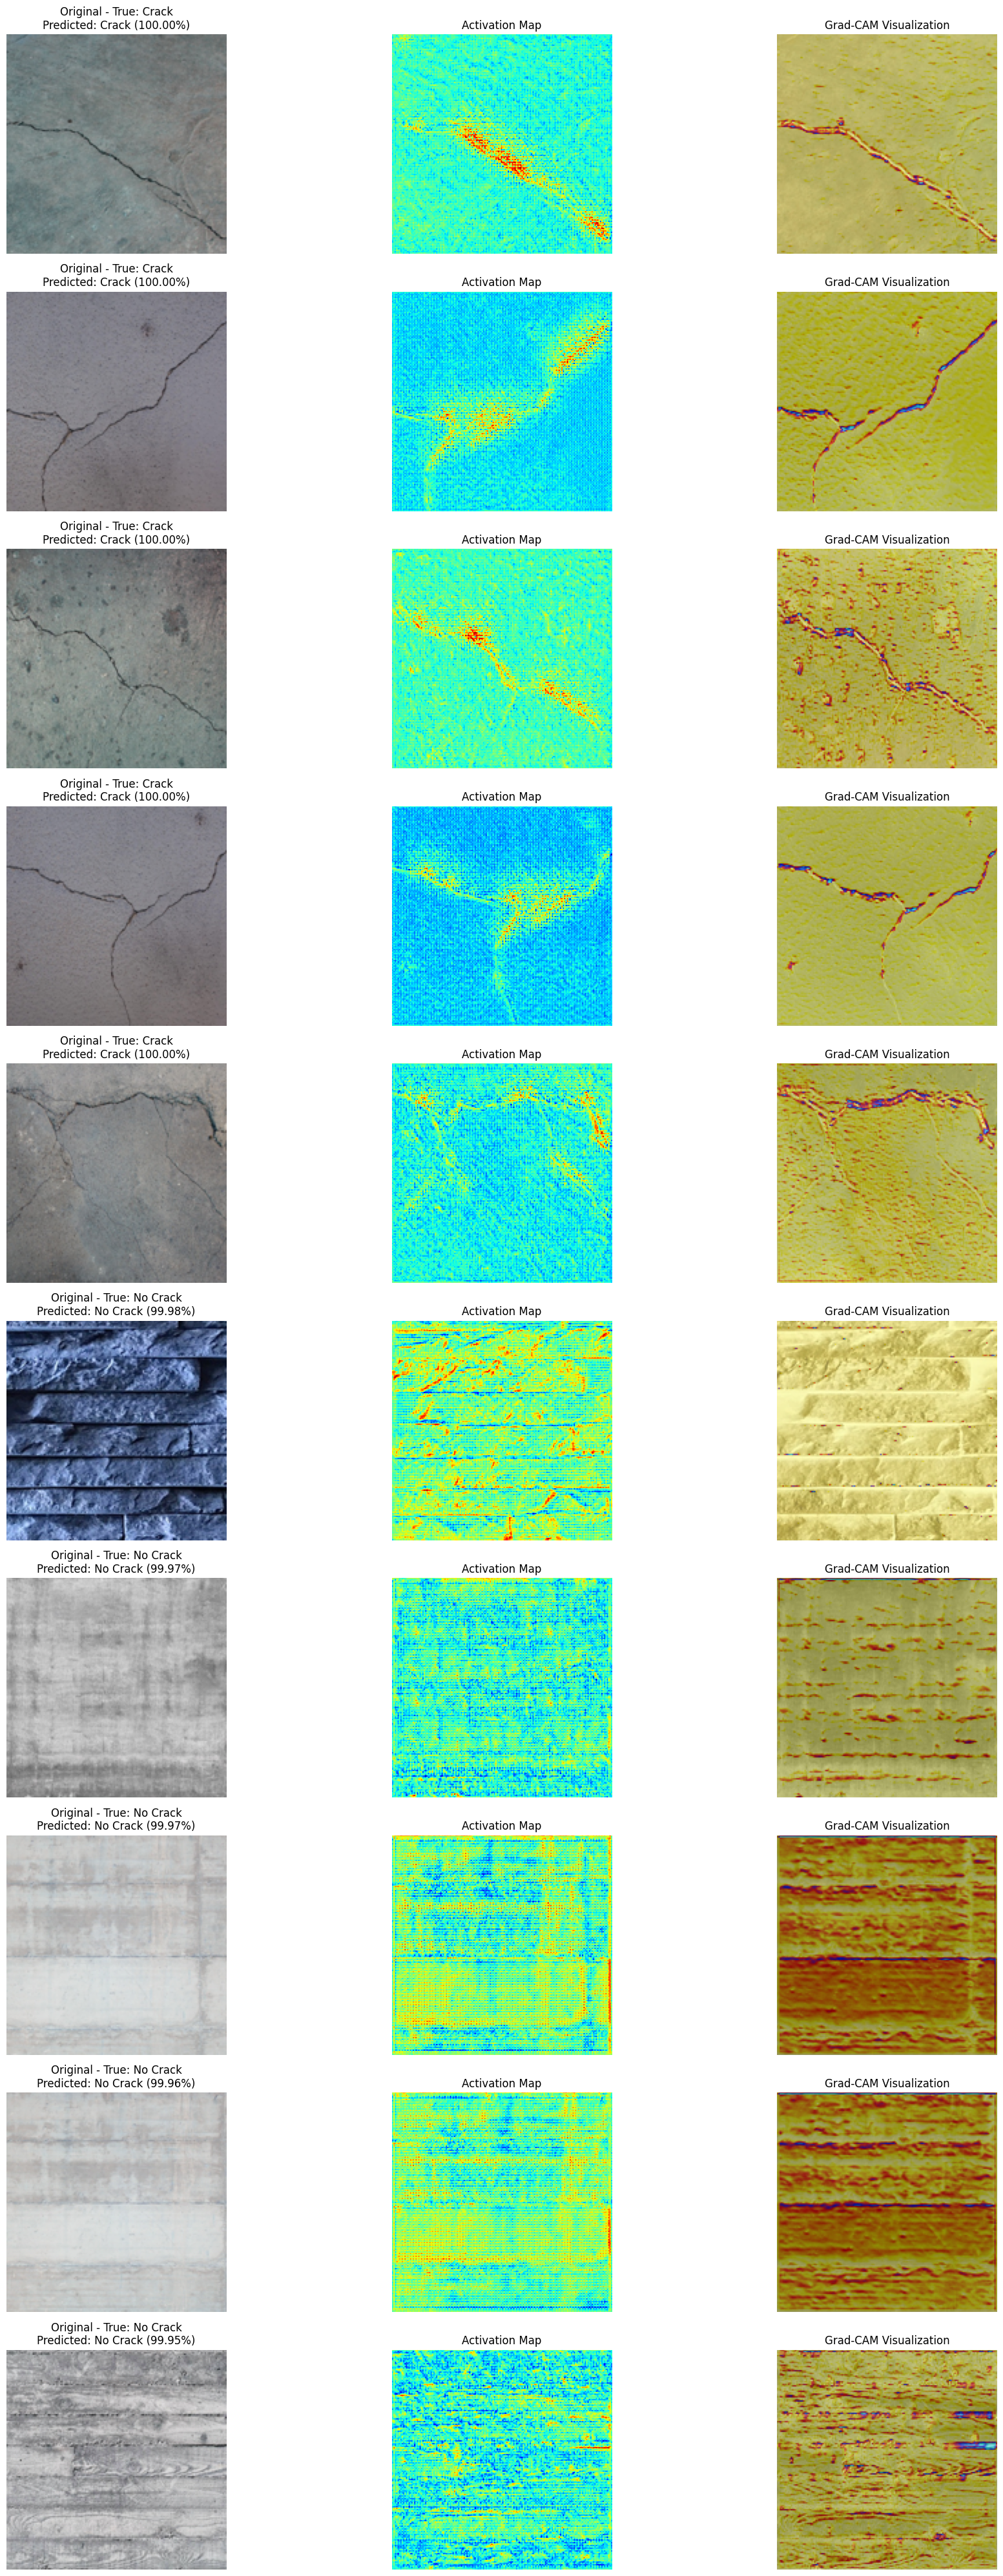

In [50]:
class WeaklyUNetWrapper(nn.Module):
    def __init__(self, model):
        super(WeaklyUNetWrapper, self).__init__()
        self.model = model
    
    def forward(self, x):
        classification, _ = self.model(x)
        return classification

# Grad-CAM Instance
wrapped_model = WeaklyUNetWrapper(model)
target_layer = model.enc1
cam = GradCAM(model=wrapped_model, target_layers=[target_layer])

def visualize_random_samples(num_samples=5):
    print("Loading saved predictions...")
    saved_data = np.load('model_predictions.npy', allow_pickle=True).item()
    predictions = saved_data['predictions']
    probabilities = saved_data['probabilities']
    labels = saved_data['labels']
    paths = saved_data['paths']
    
    # Get indices for each class
    crack_indices = np.where(labels == 0)[0]
    noncrack_indices = np.where(labels == 1)[0]
    
    # Randomly select indices from each class
    selected_indices = np.concatenate([
        np.random.choice(crack_indices, num_samples//2, replace=False),
        np.random.choice(noncrack_indices, num_samples//2, replace=False)
    ])
    np.random.shuffle(selected_indices)
    
    # Create a figure with subplots
    plt.figure(figsize=(20, 4*num_samples))
    
    for idx, sample_idx in enumerate(selected_indices):
        image_path = paths[sample_idx]
        pred = probabilities[sample_idx]
        pred_label = "Crack" if predictions[sample_idx] < 0.5 else "No Crack"
        true_label = "Crack" if labels[sample_idx] == 0 else "No Crack"
        confidence = pred if pred > 0.5 else 1 - pred
        
        # Load and process image
        img = Image.open(image_path)
        input_tensor = test_transforms(img)
        input_tensor = input_tensor.unsqueeze(0)
        
        # Get model prediction and activation map
        with torch.no_grad():
            _, feature_maps = model(input_tensor)
            
            # Get activation map
            activation = torch.sigmoid(feature_maps)
            activation = F.interpolate(activation, size=(img_size, img_size), mode='bilinear', align_corners=False)
            activation_map = activation[0, 0].cpu().numpy()
            activation_map = 1-activation_map
        
        # Get Grad-CAM visualization
        grayscale_cam = cam(input_tensor=input_tensor, targets=None)[0, :]
        rgb_img = np.array(img.resize((img_size, img_size))) / 255.0
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
        
        # Plot original and Grad-CAM
        plt.subplot(num_samples, 2, 2*idx + 1)
        plt.imshow(rgb_img)
        plt.title(f"Original - True: {true_label}\nPredicted: {pred_label} ({confidence:.2%})")
        plt.axis('off')
        
        plt.subplot(num_samples, 3, 3*idx + 2)
        plt.imshow(activation_map, cmap='jet')
        plt.title("Activation Map")
        plt.axis('off')
        
        plt.subplot(num_samples, 2, 2*idx + 2)
        plt.imshow(visualization)
        plt.title("Grad-CAM Visualization")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def visualize_top_confidence_samples(num_samples=5, skip=0):
    print("Loading saved predictions...")
    saved_data = np.load('model_predictions.npy', allow_pickle=True).item()
    predictions = saved_data['predictions']
    probabilities = saved_data['probabilities']
    labels = saved_data['labels']
    paths = saved_data['paths']
    
    # Get indices for each class
    crack_indices = np.where(labels == 0)[0]
    noncrack_indices = np.where(labels == 1)[0]
    
    # Get confidence scores for each class
    crack_scores = [(idx, probabilities[idx]) for idx in crack_indices]
    noncrack_scores = [(idx, probabilities[idx]) for idx in noncrack_indices]
    
    # Sort by confidence
    crack_scores.sort(key=lambda x: x[1])
    noncrack_scores.sort(key=lambda x: x[1], reverse=True)
    
    # Remove duplicates based on path in noncrack_scores
    seen_paths = set()
    noncrack_scores = [
        (idx, score) for idx, score in noncrack_scores
        if paths[idx] not in seen_paths and not seen_paths.add(paths[idx])
    ]
    crack_scores = [
        (idx, score) for idx, score in crack_scores
        if paths[idx].startswith('data/test/crack/Volker')
    ]
    
    # Print top confidence scores
    print("Top confidence scores:")
    print("Cracks:")
    for idx, score in crack_scores[skip:skip+num_samples//2]:
        print(f"{paths[idx]}: {score:.2%}")
    print("Non-cracks:")
    for idx, score in noncrack_scores[skip:skip+num_samples//2]:
        print(f"{paths[idx]}: {(1-score):.2%}")
    
    # Select top confident samples from each class
    selected_indices = (
        [idx for idx, _ in crack_scores[skip:skip+num_samples//2]] +
        [idx for idx, _ in noncrack_scores[skip:skip+num_samples//2]]
    )
    
    # Create a figure with subplots
    plt.figure(figsize=(20, 4*num_samples))
    
    for plot_idx, sample_idx in enumerate(selected_indices):
        image_path = paths[sample_idx]
        pred = probabilities[sample_idx]
        pred_label = "Crack" if predictions[sample_idx] < 0.5 else "No Crack"
        true_label = "Crack" if labels[sample_idx] == 0 else "No Crack"
        confidence = pred if pred > 0.5 else 1 - pred
        
        # Load and process image
        img = Image.open(image_path)
        input_tensor = test_transforms(img)
        input_tensor = input_tensor.unsqueeze(0)
        
        # Get model prediction and activation map
        with torch.no_grad():
            _, feature_maps = model(input_tensor)
            
            # Get activation map
            activation = torch.sigmoid(feature_maps)
            activation = F.interpolate(activation, size=(img_size, img_size), mode='bilinear', align_corners=False)
            activation_map = activation[0, 0].cpu().numpy()
            activation_map = 1-activation_map
        
        # Get Grad-CAM visualization
        grayscale_cam = cam(input_tensor=input_tensor, targets=None)[0, :]
        rgb_img = np.array(img.resize((img_size, img_size))) / 255.0
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
        visualization = 255-visualization
        
        # Plot original, activation map, and Grad-CAM
        plt.subplot(num_samples, 3, 3*plot_idx + 1)
        plt.imshow(rgb_img)
        plt.title(f"Original - True: {true_label}\nPredicted: {pred_label} ({confidence:.2%})")
        plt.axis('off')
        
        plt.subplot(num_samples, 3, 3*plot_idx + 2)
        plt.imshow(activation_map, cmap='jet')
        plt.title("Activation Map")
        plt.axis('off')
        
        plt.subplot(num_samples, 3, 3*plot_idx + 3)
        plt.imshow(visualization)
        plt.title("Grad-CAM Visualization")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize samples with highest confidence
visualize_top_confidence_samples(10, skip=10)

## Results

Cracks are visible in the activation map and Grad-CAM visualizations for the first layer, indicating that the model is effectively identifying cracks in the images. 

## Step 7: Save the Model
Save the trained model for deployment.

In [51]:
torch.save(model.state_dict(), "crack_detection_model.pth")
print("Model saved successfully!")

Model saved successfully!
